In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from skimage.io import imread_collection

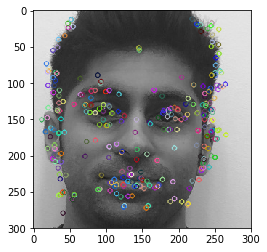

In [2]:
#example of SURF keypoints
image = cv2.imread('train_faces/66/face1.jpg', 0)
surf = cv2.xfeatures2d.SURF_create()
kp, desc = surf.detectAndCompute(image, None)
image = cv2.drawKeypoints(image, kp, None)
plt.imshow(image)

In [3]:
#grab SURF features for each image
folders = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21,22,24,
               33,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,
               51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,
               71,72,73,74,75,76,77,78,79,80,81]

surf_features = []
label = []
surf = cv2.xfeatures2d.SURF_create()

#loop through images in all folders to get surf decriptors for every image
for fldr in folders:
    col_dir = f'cw_faces/{fldr}/*'
    col = imread_collection(col_dir)
    for image in col:
        kp, desc = surf.detectAndCompute(image, None)
        surf_features.append(desc)
        label.append(fldr)

In [4]:
#concatenate all surf features for KMeans training
concatenated_surf_features = np.concatenate(surf_features)
k = 256
kmeans = KMeans(k)
kmeans.fit(concatenated_surf_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=256, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#use KMeans to predict on surf features. This will give us the input for our model.
kmeans_features = []
for d in surf_features:
    c = kmeans.predict(d)
    kmeans_features.append(np.array([np.sum(c == ci) for ci in range(k)]))
kmeans_features = np.array(kmeans_features)

In [8]:
#convert data to proper format for shuffling
kmeans_features = np.float32(kmeans_features)
label = np.array(label)

# Shuffle Samples
shuffle = np.random.permutation(len(kmeans_features))
kmeans_features = kmeans_features[shuffle]
label = label[shuffle]    

#split data into train and test sets
X_train = kmeans_features[:750]
X_test = kmeans_features[750:]
y_train = label[:750]
y_test = label[750:]

In [9]:
#Build and train SVM model
svm_surf = svm.LinearSVC()
svm_surf.fit(X_train, y_train)

/Users/eijaz/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [11]:
#get predictions and get accuracy of SVM model on the test set
y_pred_svm = svm_surf.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred_svm)))

Accuracy: 0.8833333333333333


In [33]:
#train final SVM model on all data
svm_surf.fit(kmeans_features, label)

/Users/eijaz/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [34]:
#save final SVM model
joblib.dump(svm_surf, 'svm_surf.pkl')

['svm_surf.pkl']

In [ ]:
#save KMeans model
joblib.dump(kmeans, 'kmeans_surf.pkl')

In [25]:
#one-hot encode target column
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [26]:
#get number of columns in training data
n_cols = X_train.shape[1]
early_stopping_monitor = EarlyStopping(patience=2)

#create model
mlp_surf = Sequential()

#add model layers
mlp_surf.add(Dense(1024, activation='relu', input_shape=(n_cols,)))
mlp_surf.add(Dense(1024, activation='relu'))
mlp_surf.add(Dense(1024, activation='relu'))
mlp_surf.add(Dense(82, activation='softmax'))

In [27]:
#compile model using mse as a measure of model performance
mlp_surf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
#train model
mlp_surf.fit(X_train, y_train_cat, validation_data=(X_test,y_test_cat), epochs=30, callbacks=[early_stopping_monitor])

Train on 750 samples, validate on 180 samples
Epoch 1/30
750/750 [==============================] - 1s 966us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.6289 - val_acc: 0.8389
Epoch 2/30
750/750 [==============================] - 1s 943us/step - loss: 3.5141e-04 - acc: 1.0000 - val_loss: 0.5617 - val_acc: 0.8611
Epoch 3/30
750/750 [==============================] - 1s 890us/step - loss: 2.3190e-04 - acc: 1.0000 - val_loss: 0.5449 - val_acc: 0.8722
Epoch 4/30
750/750 [==============================] - 1s 782us/step - loss: 1.8149e-04 - acc: 1.0000 - val_loss: 0.5385 - val_acc: 0.8722
Epoch 5/30
750/750 [==============================] - 1s 783us/step - loss: 1.4811e-04 - acc: 1.0000 - val_loss: 0.5338 - val_acc: 0.8667
Epoch 6/30
750/750 [==============================] - 1s 773us/step - loss: 1.1854e-04 - acc: 1.0000 - val_loss: 0.5263 - val_acc: 0.8667
Epoch 7/30
750/750 [==============================] - 1s 771us/step - loss: 9.6106e-05 - acc: 1.0000 - val_loss: 0.5228 - val_acc:

In [40]:
#save MLP model
mlp_surf.save('mlp_surf.h5')